In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections

from utils import TimeWindow, TripInterval, TripStats
from tsp import backwards_search, restore, smart_trip, compute_arrival_time, compute_nrests_between, push_up_nearest_rest, smallest_nonzero

%matplotlib inline

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [9]:


WINDOWS = (TimeWindow(10,15), 
           TimeWindow(3,18), 
           TimeWindow(10,18), 
           TimeWindow(15,35), 
           TimeWindow(40,45), 
           TimeWindow(75, 100), 
           TimeWindow(75,100))
travel_times = (6,2,4,10,10,15)

WINDOWS = (TimeWindow(0,10), 
           TimeWindow(5,9),
           TimeWindow(40,40))
travel_times = (9,10)

# WINDOWS = (TimeWindow(10,20), TimeWindow(100,100))
# travel_times = (10,)

# WINDOWS = (TimeWindow(0,10), TimeWindow(5,9), TimeWindow(40,40))
# travel_times = (9,10)

TS = TripStats(WINDOWS, travel_times)
temp = smart_trip(TS)

5
Location: 5, Branch: B
Location: 4, Branch: C
Location: 3, Branch: B
Location: 2, Branch: C
Location: 1, Branch: B
Location: 0, Branch: A
0


In [10]:
temp

(True, (False, 0, <utils.TripStats at 0x25e4b3d7ef0>))

In [3]:
TS

In [4]:
t_d = temp[1].t_d
t_a = temp[1].t_a
print(t_d, t_a)

array('f', [0.0, 9.0, 40.0]) array('f', [0.0, 30.0, 40.0])


In [5]:


# legs = pd.DataFrame([
#         ('drive', 89,100, 6),
#         ('rest', 79, 89, 6),
#         ('drive', 75,79, 6),
#         ('drive', 68, 75, 5),
#         ('rest', 58, 68, 5),
#         ('drive', 55, 58, 5),
#         ('rest', 45, 55, -100),
#         ('drive', 35, 45, 4),
#         ('drive', 34, 35, 3),
#         ('rest', 24, 34, 3),
#         ('drive', 21, 24, 3),
#         ('wait', 18, 21, 3),
#         ('drive', 16, 18, 2),
#         ('drive', 10, 16, 1)], columns = ['type', 'end', 'start', 'last_stop'])

legs = pd.DataFrame([
  ('drive', 30.0, 40.0, 2),
  ('wait', 29.0, 30.0, -1),
  ('rest', 19.0, 29.0, -1),
  ('rest', 9.0, 19.0, -1),
  ('drive', 0.0, 9.0, 1)
], columns = ['type', 'end', 'start', 'last_stop'])
    
def compute_rest_times(legs, last_stop):
    temp = legs.loc[(legs['type'] == 'rest') & (legs['last_stop'] == last_stop), :]
    temp = temp['start'] - temp['end']
    return temp.sum()  
    

def compute_slope(p0, p1, rest_time):
        return (p1[1] - p0[1])/(p1[0] - rest_time - p0[0])

In [6]:
s = len(WINDOWS)
m = list()
for i in reversed(range(s)):
    rest_times = compute_rest_times(legs, i)
    p0 = [t_a[i-1], 10*(i-1)]
    p1 = [t_d[i], 10*i]
    m.append(compute_slope(p0, p1, rest_times))
    #print(rest_times, p0, p1)
    
m = list(reversed(m))

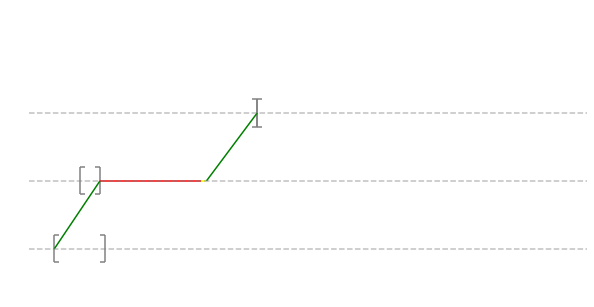

In [7]:
%matplotlib inline

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.axis('off')
ax.set_ylim(0 - 5, 10*len(WINDOWS)+5)
ax.set_xlim(0 - 5, 100 + 5)

#create line segments for time windows
time_segments_coordinates = list()
for i, w in enumerate(WINDOWS):
    
    # vertical bars
    x_e, x_l = w.e, w.l
    y0, y1 = 10*i - 2, 10*i + 2
    
    time_segments_coordinates.append([(x_e,y0), (x_e, y1)])
    time_segments_coordinates.append([(x_l, y0), (x_l, y1)])
    
    # horizontal bars
    time_segments_coordinates.append([(x_e, y0), (x_e + 1, y0)])
    time_segments_coordinates.append([(x_e, y1), (x_e + 1, y1)])
    time_segments_coordinates.append([(x_l, y0), (x_l - 1, y0)])
    time_segments_coordinates.append([(x_l, y1), (x_l - 1, y1)])
    
    

T = 10*len(travel_times)
leg_colors = list()
leg_segments = list()
for leg in legs.itertuples(index=False):
    
    if leg[0] == 'drive':
        leg_colors.append('green')
        x0, x1 = leg[1], leg[2]
        y1 = T
        y0 = y1 - m[leg[3]]*(x1 - x0)
        T -= y1 - y0
        leg_segments.append([(x0, y0), (x1, y1)])
        
    elif leg[0] == 'rest':
        leg_colors.append('red')
        x0, x1 = leg[1], leg[2]
        y0, y1 = T, T
        leg_segments.append([(x0, y0), (x1, y1)])
        
    elif leg[0] == 'wait':
        leg_colors.append('yellow')
        x0, x1 = leg[1], leg[2]
        y0, y1 = T, T
        leg_segments.append([(x0, y0), (x1, y1)])
        
        
leg_segments = collections.LineCollection(leg_segments, colors=leg_colors)
time_segments = collections.LineCollection(time_segments_coordinates, colors='grey')

for i, _ in enumerate(WINDOWS):
    ax.axhline(10*i, color='grey', linestyle='--', alpha=0.5)
    
ax.add_collection(time_segments)
ax.add_collection(leg_segments)

